In [1]:
import time
import os
import random
import copy
import math
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, utils
from tensorboardX import SummaryWriter
from utils import * 
from model import * 
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision.utils import save_image
from scipy import stats

%matplotlib inline

# data I/O
data_dir = 'data' # location for dataset
save_dir = 'models' # location for parameter checkpoints and samples
dataset = 'cifar' # cifar or mnist
print_every = 50 # how many iter between print statements
save_interval = 5 # how many epoch to write checkpoint/samples
# load_params = './runs/pretrained/pcnn_lr.0.00040_nr-resnet5_nr-filters160_889.pth' # restore training from previous model checkpoint, default is None
load_params = None
load_params_1 = '../pixel-cnn-pp-baseline/models/baseline_pcnn_lr:0.00020_nr-resnet5_nr-filters160_64.pth'
load_params_2 = '../pixel-cnn-pp-sideways/models/sideways_pcnn_lr:0.00020_nr-resnet5_nr-filters160_59.pth'

# model
nr_resnet = 5 # num of resid blocks per stage
nr_filters = 160 # num of filters 
nr_logistic_mix = 10 # num of logistic components in mixture
lr = 0.0002 # base learning rate
lr_decay = 0.999995 # lr decay after every step in optimization
batch_size = 16 # batch size, default is 64
max_epochs = 5000 # max num of epochs
seed = 1 # random seed

# reproducibility
torch.manual_seed(seed)
np.random.seed(seed)
model_name = 'pcnn_lr:{:.5f}_nr-resnet{}_nr-filters{}'.format(lr, nr_resnet, nr_filters)
torch.cuda.set_device(0)
device_1 = torch.device("cuda:0")
device_2 = torch.device("cuda:1")

In [5]:
# assert not os.path.exists(os.path.join('runs', model_name)), '{} already exists!'.format(model_name)

writer = SummaryWriter(log_dir=os.path.join('runs', model_name))
sample_batch_size = 16
obs = (1, 28, 28) if 'mnist' in dataset else (3, 32, 32)
input_channels = obs[0]
rescaling     = lambda x : (x - .5) * 2.
rescaling_inv = lambda x : .5 * x  + .5
kwargs = {'num_workers':1, 'pin_memory':True, 'drop_last':True}
ds_transforms = transforms.Compose([transforms.ToTensor(), rescaling])
if 'mnist' in dataset : 
    train_loader = torch.utils.data.DataLoader(datasets.MNIST(data_dir, download=True, 
                        train=True, transform=ds_transforms), batch_size=batch_size, 
                            shuffle=True, **kwargs)
    
    test_loader  = torch.utils.data.DataLoader(datasets.MNIST(data_dir, train=False, 
                    transform=ds_transforms), batch_size=batch_size, shuffle=True, **kwargs)
    
    loss_op   = lambda real, fake, device : discretized_mix_logistic_loss_1d(real, fake, device)
    sample_op = lambda x, device : sample_from_discretized_mix_logistic_1d(x.to(device), nr_logistic_mix, device)
elif 'cifar' in dataset : 
    train_loader = torch.utils.data.DataLoader(datasets.CIFAR10(data_dir, train=True, 
        download=True, transform=ds_transforms), batch_size=batch_size, shuffle=True, **kwargs)
    
    test_loader  = torch.utils.data.DataLoader(datasets.CIFAR10(data_dir, train=False, 
                    transform=ds_transforms), batch_size=batch_size, shuffle=True, **kwargs)
    
    loss_op   = lambda real, fake, device : discretized_mix_logistic_loss(real, fake, device)
    sample_op = lambda x, device : sample_from_discretized_mix_logistic(x.to(device), nr_logistic_mix, device)
    sample_op_duo = lambda x, device : sample_from_discretized_mix_logistic(x.to(device), nr_logistic_mix*2, device)
else :
    raise Exception('{} dataset not in {mnist, cifar10}'.format(dataset))
    
model_1 = PixelCNN(nr_resnet=nr_resnet, nr_filters=nr_filters, 
            input_channels=input_channels, nr_logistic_mix=nr_logistic_mix) # Note: Using Sideways
model_1 = model_1.cuda()
if load_params_1:
    load_part_of_model(model_1, load_params_1)
    # model.load_state_dict(torch.load(load_params))
    print('model parameters loaded')
    
optimizer_1 = optim.Adam(model_1.parameters(), lr=lr)
scheduler_1 = lr_scheduler.StepLR(optimizer_1, step_size=1, gamma=lr_decay)

model_2 = PixelCNNSideways(nr_resnet=nr_resnet, nr_filters=nr_filters, 
            input_channels=input_channels, nr_logistic_mix=nr_logistic_mix) # Note: Using Sideways
model_2 = model_2.cuda()
model_2.to(device_2)
if load_params_2:
    load_part_of_model(model_2, load_params_2)
    # model.load_state_dict(torch.load(load_params))
    print('model parameters loaded')
    
optimizer_2 = optim.Adam(model_2.parameters(), lr=lr)
scheduler_2 = lr_scheduler.StepLR(optimizer_2, step_size=1, gamma=lr_decay)

# x is top to bottom, y is left to right
def sample(model, device, vertical=True, data=None, x1=-1, x2=-1, y1=-1, y2=-1):
    model.train(False)
    if data is None:
        data = torch.zeros(sample_batch_size, obs[0], obs[1], obs[2])
        x1, y1 = 0, 0 
        x2, y2 = obs[1], obs[2]
    else:
        print("Filling occlusion. x:",x1,x2," y",y1,y2)
    data = data.cuda().to(device)
    if vertical:
        for i in tqdm(range(x1,x2)):     
            for j in range(y1,y2):
                data_v = Variable(data, volatile=True)
                out   = model(data_v, sample=True)
                out_sample = sample_op(out, device)
                data[:, :, i, j] = out_sample.data[:, :, i, j]
    else:
        for j in tqdm(range(y1,y2)): # Note: Sampling is flipped here to fill in js first
            for i in range(x1,x2):     
                data_v = Variable(data, volatile=True)
                out   = model(data_v, sample=True)
                out_sample = sample_op(out, device)
                data[:, :, i, j] = out_sample.data[:, :, i, j]
    return data, out

# x is top to bottom, y is left to right
def sample_duo(model_1, model_2, device_1, device_2, vertical=True, data=None, x1=-1, x2=-1, y1=-1, y2=-1):
    model_1.train(False)
    model_2.train(False)
    if data is None:
        data = torch.zeros(sample_batch_size, obs[0], obs[1], obs[2])
        x1, y1 = 0, 0 
        x2, y2 = obs[1], obs[2]
    else:
        print("Filling occlusion. x:",x1,x2," y",y1,y2)
    data = data.cuda().to(device_1)
    if vertical:
        for i in tqdm(range(x1,x2)):     
            for j in range(y1,y2):
                data_v = Variable(data, volatile=True)
                out_1 = model_1(data_v.to(device_1), sample=True)
                out_2  = model_2(data_v.to(device_2), sample=True).to(device_1)
                out = torch.cat((out_1,out_2),dim=1)
                out_sample = sample_op_duo(out, device_1)
                data[:, :, i, j] = out_sample.data[:, :, i, j]
    else:
        for j in tqdm(range(y1,y2)): # Note: Sampling is flipped here to fill in js first
            for i in range(x1,x2):     
                data_v = Variable(data, volatile=True)
                out_1 = model_1(data_v.to(device_1), sample=True)
                out_2  = model_2(data_v.to(device_2), sample=True).to(device_1)
                out = torch.mean(torch.stack([out_1, out_2]), dim=0)
                out_sample = sample_op_duo(out, device)
                data[:, :, i, j] = out_sample.data[:, :, i, j]
    return data, out

def fast_sample_solo(model, device, vertical=True, data=None, x1=-1, x2=-1, y1=-1, y2=-1):
    model.train(False)
    if data is None:
        data = torch.zeros(sample_batch_size, obs[0], obs[1], obs[2])
        x1, y1 = 0, 0 
        x2, y2 = obs[1], obs[2]
    data = data.cuda().to(device)
    for z in tqdm(range(max(x2-x1,y2-y1)*4-4)):
        i = 0
        j = z
        inds = []
        while j >= 0 and i < x2:
            if j < y2:
                inds.append((i,j))
            i += 1
            j -= 3
        if len(inds) == 0:
            continue
        data_v = Variable(data, volatile=True)
        out   = model(data_v, sample=True)
        out_sample = sample_op(out, device)
        for ind in inds:
            i, j = ind
            i = i + x1
            j = j + y1
            if not vertical: # It's going sideways
                i, j = j, i 
            data[:, :, i, j] = out_sample.data[:, :, i, j]
    return data

def fast_sample_duo(model_1, model_2, device_1, device_2):
    model_1.train(False)
    model_2.train(False)
    data = torch.zeros(sample_batch_size, obs[0], obs[1], obs[2])
    data = data.cuda().to(device_1)
    inftime = 0
    for z in tqdm(range(max(obs[1],obs[2])*5-5)):
        i = 0
        j = z
        inds = []
        while j >= 0 and i < obs[1] and j >= i:
            if j < obs[2]:
                inds.append((i,j))
            i += 1
            j -= 4
          
        if len(inds) == 0:
            continue
        stime = time.time()
        data_v_1 = Variable(data, volatile=True)
        out_1   = model_1(data_v_1, sample=True)
        out_sample_1 = sample_op(out_1, device_1)
        etime = time.time()
        
        stime2 = time.time()
        data_v_2 = Variable(data.to(device_2), volatile=True)
        out_2   = model_2(data_v_2, sample=True)
        out_sample_2 = sample_op(out_2, device_2)
        etime2 = time.time()
        inftime += max(etime-stime, etime2-stime2)
        
        for ind in inds:
            i, j = ind
            data[:, :, i, j] = out_sample_1.data[:, :, i, j]
            data[:, :, j, i] = out_sample_2.data[:, :, j, i]
    return data, inftime

Files already downloaded and verified
added 100.0 of params
model parameters loaded
added 100.0 of params
model parameters loaded


In [3]:
print('starting training')
writes = 0
for epoch in range(max_epochs):
    model_1.train(True)
    model_2.train(True)
    torch.cuda.synchronize()
    train_loss_1, train_loss_2, train_JSD = 0., 0., 0.
    time_ = time.time()
    model_1.train()
    model_2.train()
    
    for batch_idx, (input,_) in enumerate(tqdm(train_loader)):
        break
        input = input.cuda()
        input_var_1 = Variable(input)
        input_var_2 = Variable(input.to(device_2))
        output_1 = model_1(input_var_1)
        output_2 = model_2(input_var_2)
        loss_1, loss_2, JSD = discretized_mix_logistic_loss_joint(input_var_1, output_1, output_2.to(device_1), device_1)
        loss_2 = loss_2.to(device_2)
        optimizer_1.zero_grad()
        optimizer_2.zero_grad()
        loss_1.backward(retain_graph=True)
        loss_2.backward()
        optimizer_1.step()
        optimizer_2.step()
        train_loss_1 += loss_1.data.item()
        train_loss_2 += loss_2.data.item()
        train_JSD += JSD.data.item()
        if (batch_idx +1) % print_every == 0 : 
            deno = print_every * batch_size * np.prod(obs) * np.log(2.)
            writer.add_scalar('train/bpd', (train_loss_1 / deno), writes)
            print('loss 1 : {:.4f}, time : {:.4f}'.format(
                (train_loss_1 / deno), 
                (time.time() - time_)))
            print('loss 2 : {:.4f}, time : {:.4f}'.format(
                (train_loss_2 / deno), 
                (time.time() - time_)))
            print('loss JSD : {:.4f}, time : {:.4f}'.format(
                (JSD / deno), 
                (time.time() - time_)))
            train_loss_1, train_loss_2 = 0., 0.
            writes += 1
            time_ = time.time()
            
    # decrease learning rate
    scheduler_1.step()
    scheduler_2.step()
    
    torch.cuda.synchronize()
    model_1.eval()
    model_2.eval()
    test_loss_1, test_loss_2, test_JSD = 0., 0., 0.
    for batch_idx, (input,_) in enumerate(tqdm(test_loader)):
        input = input.cuda()
        input_var_1 = Variable(input)
        input_var_2 = Variable(input.to(device_2))
        output_1 = model_1(input_var_1)
        output_2 = model_2(input_var_2)
        loss_1 = discretized_mix_logistic_loss(input_var_1, output_1, device_1)
        loss_2 = discretized_mix_logistic_loss(input_var_2, output_2, device_2)
        # loss_1 = loss_op(input_var, output_1, device_1) #TODO: FINISH 2 MODEL VERSION
        # loss_2 = loss_op(input_var_2, output_2, device_2) #TODO: FINISH 2 MODEL VERSION
        test_loss_1 += loss_1.data.item()
        test_loss_2 += loss_2.data.item()
        # test_JSD += JSD.data.item()
        del input, input_var_1, input_var_2, loss_1, loss_2, output_1, output_2 # JSD
    deno = batch_idx * batch_size * np.prod(obs) * np.log(2.)
    writer.add_scalar('test/bpd', (test_loss_1 / deno), writes)
    print('test loss 1: %s' % (test_loss_1 / deno))
    print('test loss 2: %s' % (test_loss_2 / deno))
    # print('test loss JSD: %s' % (test_JSD / deno))
    
    if (epoch + 1) % save_interval == 0: 
        torch.save(model_1.state_dict(), 'models/model_1_{}_{}.pth'.format(model_name, epoch))
        torch.save(model_2.state_dict(), 'models/model_2_{}_{}.pth'.format(model_name, epoch))
        # print('sampling...')
        # sample_t_1 = sample(model_1)
        # sample_t_1 = rescaling_inv(sample_t_1)
        # sample_t_2 = sample(model_2)
        # sample_t_2 = rescaling_inv(sample_t_2)
        # utils.save_image(sample_t,'images/model_1_{}_{}.png'.format(model_name, epoch), nrow=5, padding=0)
        # utils.save_image(sample_t_2,'images/model_2_{}_{}.png'.format(model_name, epoch), nrow=5, padding=0)

  0%|          | 0/3125 [00:00<?, ?it/s]

starting training


  0%|          | 0/3125 [00:00<?, ?it/s]
/opt/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/625 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh i

test loss 1: 3.046616136907493
test loss 2: 3.052509843076013


  0%|          | 0/3125 [00:00<?, ?it/s]

test loss 1: 3.04661613837743
test loss 2: 3.052509844178466


  6%|▌         | 36/625 [00:13<03:45,  2.61it/s]

KeyboardInterrupt: 

In [5]:
img_1 = sample(model_1, device_1, vertical=True)
img_1 = rescaling_inv(img_1)
save_image(img_1,'./images/sample_model_1.png',nrow=5)

img_2 = sample(model_2, device_2, vertical=False)
img_2 = rescaling_inv(img_2)
save_image(img_2,'./images/sample_model_2.png',nrow=5)

100%|██████████| 32/32 [04:00<00:00,  7.51s/it]


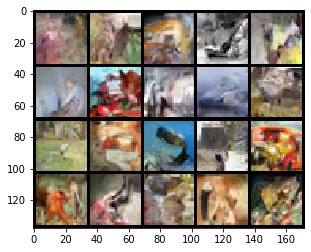

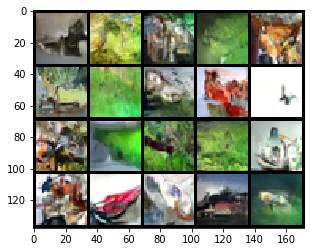

In [6]:
image = mpimg.imread('./images/sample_model_1.png')
plt.imshow(image)
plt.show()

image = mpimg.imread('./images/sample_model_2.png')
plt.imshow(image)
plt.show()

In [11]:
## Code to measure image completion ability
# Make sure batch_size = sample_batch_size
def worst_case(model_1, model_2, device_1, device_2):
    losses_1 = []
    losses_2 = []
    losses_3 = []
    for batch_idx, (input,_) in enumerate(test_loader):
        if batch_idx > 0:
            break
        print("Batch idx:", batch_idx)
        left = random.randint(5,10)
        right = random.randint(32,32)
        top = random.randint(0,0)
        bottom = random.randint(10,20)
        
        real = copy.deepcopy(input)
        input[:,:,top:bottom,left:right] = 0 # Mask out region
        output_1, logits_1 = sample(model_1, device_1, True, input, top, bottom, left, right)
        input[:,:,top:bottom,left:right] = 0 # Mask out region
        output_2, logits_2 = sample(model_2, device_2, False, input, top, bottom, left, right)
        # input[:,:,top:bottom,left:right] = 0 # Mask out region
        # output_3, logits_3 = sample_duo(model_1, model_2, device_1, device_2, True, input, top, bottom, left, right)
                
        #TODO: Calculate metrics?
        losses_1.append(discretized_mix_logistic_loss(real.to(device_1)[:,:,top:bottom,left:right], logits_1[:,:,top:bottom,left:right], device_1).data.item() / batch_size / np.log(2.) / (3*(bottom-top)*(right-left)))
        losses_2.append(discretized_mix_logistic_loss(real.to(device_2)[:,:,top:bottom,left:right], logits_2[:,:,top:bottom,left:right], device_2).data.item() / batch_size / np.log(2.) / (3*(bottom-top)*(right-left)))
        # losses_1.append(discretized_mix_logistic_loss(real.to(device_1), logits_1, device_1).data.item() / batch_size / np.log(2.) / np.prod(obs)
        # losses_2.append(discretized_mix_logistic_loss(real.to(device_2), logits_2, device_2).data.item() / batch_size / np.log(2.) / np.prod(obs)
        
        # losses_3.append(discretized_mix_logistic_loss(real.to(device_1)[:,:,top:bottom,left:right], logits_3[:,:,top:bottom,left:right], device_1).data.item() / batch_size / np.log(2.) / ((bottom-top)*(right-left)))
        
        for i in range(input.shape[0]):
            save_image(rescaling_inv(real)[i,:,:,:].squeeze(),'./worst_case/original/sample_'+str(batch_idx*100+i)+'.png')
            save_image(rescaling_inv(input)[i,:,:,:].squeeze(),'./worst_case/masked/sample_'+str(batch_idx*100+i)+'.png')
            save_image(rescaling_inv(output_1)[i,:,:,:].squeeze(),'./worst_case/single/sample_'+str(batch_idx*100+i)+'.png')
            save_image(rescaling_inv(output_2)[i,:,:,:].squeeze(),'./worst_case/farm/sample_'+str(batch_idx*100+i)+'.png')
            # save_image(rescaling_inv(output_3)[i,:,:,:].squeeze(),'./worst_case/farmjoint/sample_'+str(batch_idx*100+i)+'.png')
    return losses_1, losses_2, losses_3

def average_case(model_1, model_2, device_1, device_2):
    losses_1 = []
    losses_2 = []
    losses_3 = []
    for batch_idx, (input,_) in enumerate(test_loader):
        if batch_idx > 0:
            break
        print("Batch idx:", batch_idx)
        
        left = random.randint(5,15)
        right = random.randint(15,25)
        top = random.randint(5,15)
        bottom = random.randint(15,25)
        left, right = min(left,right), max(left,right)
        top, bottom = min(top,bottom), max(top,bottom)
        while left >= right or top >= bottom:
            left = random.randint(5,15)
            right = random.randint(15,25)
            top = random.randint(5,15)
            bottom = random.randint(15,25)
            left, right = min(left,right), max(left,right)
            top, bottom = min(top,bottom), max(top,bottom)
        
        real = copy.deepcopy(input)
        input[:,:,top:bottom,left:right] = 0 # Mask out region
        output_1, logits_1 = sample(model_1, device_1, True, input, top, bottom, left, right)
        input[:,:,top:bottom,left:right] = 0 # Mask out region
        output_2, logits_2 = sample(model_2, device_2, False, input, top, bottom, left, right)
        # input[:,:,top:bottom,left:right] = 0 # Mask out region
        # output_3, logits_3 = sample(model_1, model_2, device_1, device_2, True, input, top, bottom, left, right)
        
        #TODO Calculate metrics?
        losses_1.append(discretized_mix_logistic_loss(real.to(device_1)[:,:,top:bottom,left:right], logits_1[:,:,top:bottom,left:right], device_1).data.item() / batch_size / np.log(2.) / (3*(bottom-top)*(right-left)))
        if left > top:
            losses_2.append(discretized_mix_logistic_loss(real.to(device_2)[:,:,top:bottom,left:right], logits_2[:,:,top:bottom,left:right], device_2).data.item() / batch_size / np.log(2.) / (3*(bottom-top)*(right-left)))
        else: 
            losses_2.append(discretized_mix_logistic_loss(real.to(device_1)[:,:,top:bottom,left:right], logits_1[:,:,top:bottom,left:right], device_1).data.item() / batch_size / np.log(2.) / (3*(bottom-top)*(right-left)))
        # losses_3.append(discretized_mix_logistic_loss(real.to(device_1)[:,:,top:bottom,left:right], logits_3[:,:,top:bottom,left:right], device_1).data.item() / batch_size / np.log(2.) / (3*(bottom-top)*(right-left)))
            
        for i in range(input.shape[0]):
            save_image(rescaling_inv(real)[i,:,:,:].squeeze(),'./average_case/original/sample_'+str(batch_idx*100+i)+'.png')
            save_image(rescaling_inv(input)[i,:,:,:].squeeze(),'./average_case/masked/sample_'+str(batch_idx*100+i)+'.png')
            save_image(rescaling_inv(output_1)[i,:,:,:].squeeze(),'./average_case/single/sample_'+str(batch_idx*100+i)+'.png')
            if left > top+5:
                save_image(rescaling_inv(output_2)[i,:,:,:].squeeze(),'./average_case/farm/sample_'+str(batch_idx*100+i)+'.png')
            else:
                save_image(rescaling_inv(output_1)[i,:,:,:].squeeze(),'./average_case/farm/sample_'+str(batch_idx*100+i)+'.png')
            # save_image(rescaling_inv(output_3)[i,:,:,:].squeeze(),'./average_case/farmjoint/sample_'+str(batch_idx*100+i)+'.png')
    return losses_1, losses_2, losses_3

worst_losses_1, worst_losses_2, _ = worst_case(model_1, model_2, device_1, device_2)
worst_losses_1, worst_losses_2 = np.repeat(np.asarray(worst_losses_1),int(math.sqrt(batch_size))), np.repeat(np.asarray(worst_losses_2),int(math.sqrt(batch_size)))
print("worst", np.mean(worst_losses_1), np.mean(worst_losses_2))
print("2 sample t-test", stats.ttest_ind(worst_losses_1,worst_losses_2))

# average_losses_1, average_losses_2, _ = average_case(model_1, model_2, device_1, device_2)
# average_losses_1, average_losses_2 = np.asarray(average_losses_1), np.asarray(average_losses_2)
# print("average", np.mean(average_losses_1), np.mean(average_losses_2))
# print("2 sample t-test", stats.ttest_ind(np.repeat(average_losses_1,batch_size),np.repeat(average_losses_2,batch_size)))

  0%|          | 0/18 [00:00<?, ?it/s]

Batch idx: 0
Filling occlusion. x: 0 18  y 5 32


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  0%|          | 0/27 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Filling occlusion. x: 0 18  y 5 32


100%|██████████| 27/27 [01:35<00:00,  3.52s/it]


worst 18.22412477693412 17.495369514061377
2 sample t-test Ttest_indResult(statistic=inf, pvalue=0.0)


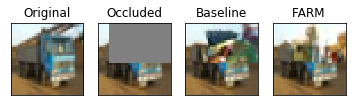

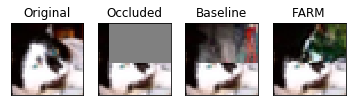

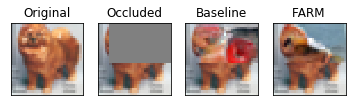

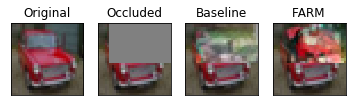

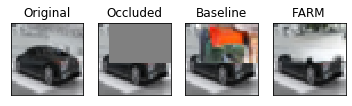

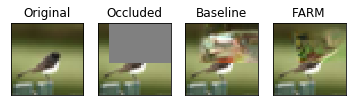

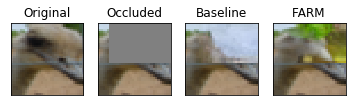

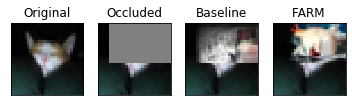

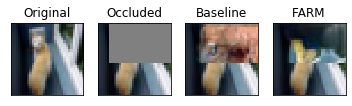

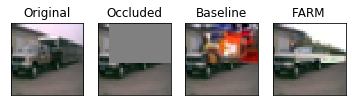

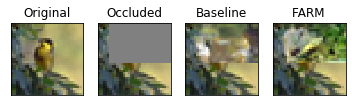

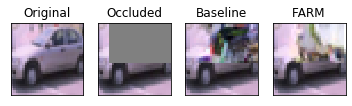

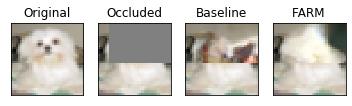

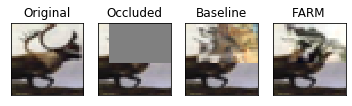

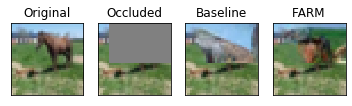

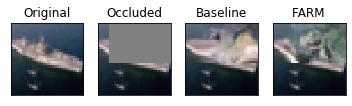

In [13]:
for i in range(batch_size):
    num = i + 100 * 0
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
    image = mpimg.imread('./worst_case/original/sample_'+str(num)+'.png')
    ax1.title.set_text('Original')
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax1.imshow(image)
    image = mpimg.imread('./worst_case/masked/sample_'+str(num)+'.png')
    ax2.title.set_text('Occluded')
    ax2.get_yaxis().set_visible(False)
    ax2.get_xaxis().set_visible(False)
    ax2.imshow(image)
    image = mpimg.imread('./worst_case/single/sample_'+str(num)+'.png')
    ax3.title.set_text('Baseline')
    ax3.get_yaxis().set_visible(False)
    ax3.get_xaxis().set_visible(False)
    ax3.imshow(image)
    image = mpimg.imread('./worst_case/farm/sample_'+str(num)+'.png')
    ax4.title.set_text('FARM')
    ax4.get_yaxis().set_visible(False)
    ax4.get_xaxis().set_visible(False)
    ax4.imshow(image)
    # image = mpimg.imread('./worst_case/farmjoint/sample_'+str(i)+'.png')
    # ax5.imshow(image)
    fig.show()

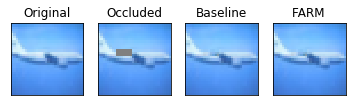

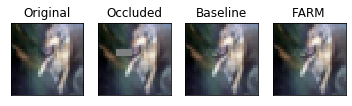

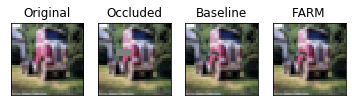

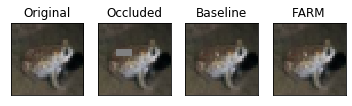

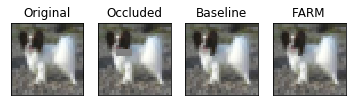

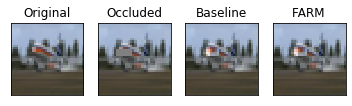

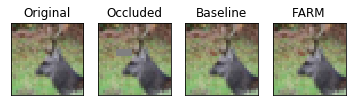

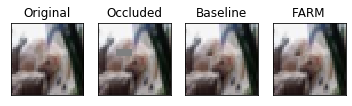

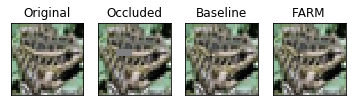

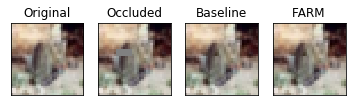

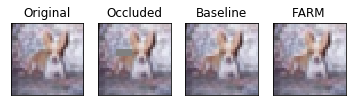

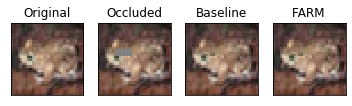

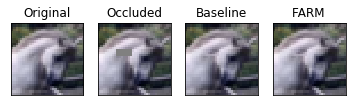

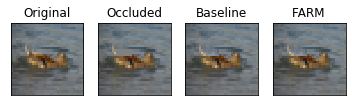

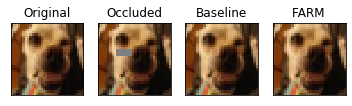

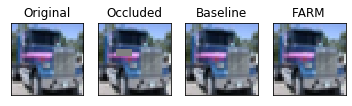

In [14]:
for i in range(batch_size):
    num = i + 100*2
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
    ax1.title.set_text('Original')
    ax2.title.set_text('Occluded')
    ax3.title.set_text('Baseline')
    ax4.title.set_text('FARM')
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    ax2.get_xaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)
    ax3.get_xaxis().set_visible(False)
    ax4.get_yaxis().set_visible(False)
    ax4.get_xaxis().set_visible(False)
    image = mpimg.imread('./average_case/original/sample_'+str(num)+'.png')
    ax1.imshow(image)
    image = mpimg.imread('./average_case/masked/sample_'+str(num)+'.png')
    ax2.imshow(image)
    image = mpimg.imread('./average_case/single/sample_'+str(num)+'.png')
    ax3.imshow(image)
    image = mpimg.imread('./average_case/farm/sample_'+str(num)+'.png')
    ax4.imshow(image)
    # image = mpimg.imread('./average_case/farmjoint/sample_'+str(i)+'.png')
    # ax5.imshow(image)
    fig.show()

In [3]:
## Speed tests
# img_1, logits = sample(model_1, device_1, vertical=True)
# img_1 = rescaling_inv(img_1)
# save_image(img_1,'./images/slow_sample.png',nrow=5)

img_2 = fast_sample_duo(model_1, model_2, device_1, device_2)
img_2 = rescaling_inv(img_2)
save_image(img_2,'./images/fast_sample.png',nrow=5)

  0%|          | 0/155 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:161: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
100%|██████████| 155/155 [01:12<00:00,  2.15it/s]


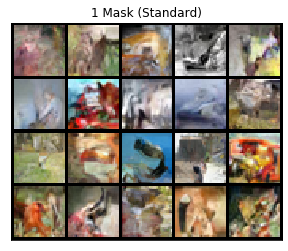

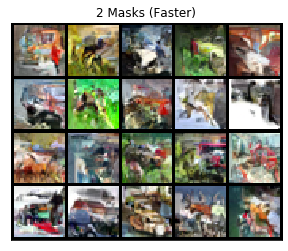

In [12]:
image = mpimg.imread('./images/slow_sample.png')
plt.title('1 Mask (Standard)')
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.show()

image = mpimg.imread('./images/fast_sample.png')
plt.imshow(image)
plt.title('2 Masks (Faster)')
plt.xticks([])
plt.yticks([])
plt.show()

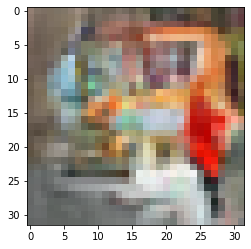

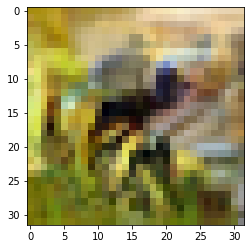

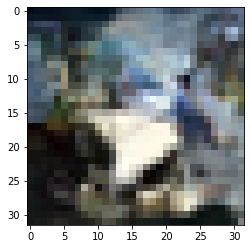

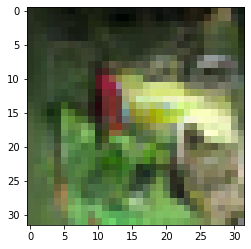

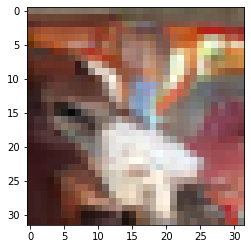

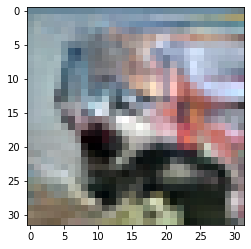

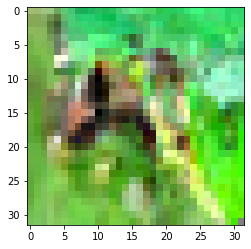

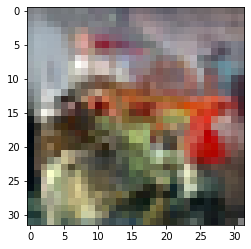

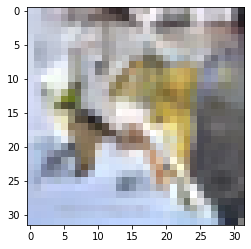

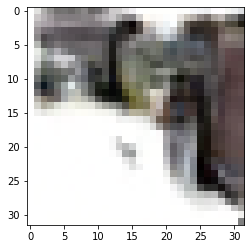

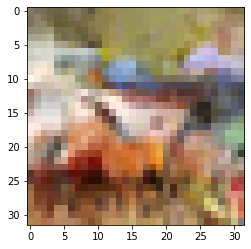

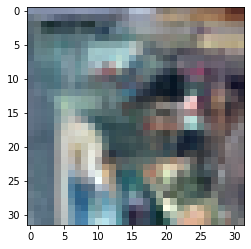

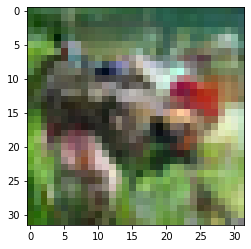

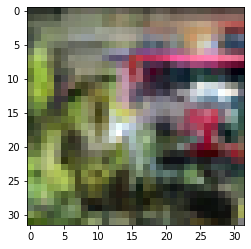

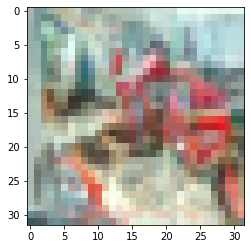

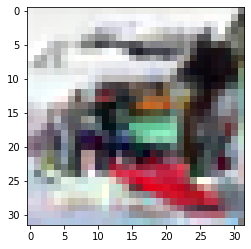

In [10]:
for i in range(16):
    num = i + 100*0
    image = mpimg.imread('./images/slowsample/fast_sample_'+str(num)+'.png')
    plt.imshow(image)
    plt.show()